![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx to create NLP SQL queries against SingleStoreDB

This notebook contains the steps and code to demonstrate SQL Codegen in watsonx.ai with SingleStoreDB as the database. It introduces commands to create a prompt based on a hypothetical database schema, NLP questioning, and SQL codegen.

Some familiarity with Python is helpful. This notebook uses Python 3.10.

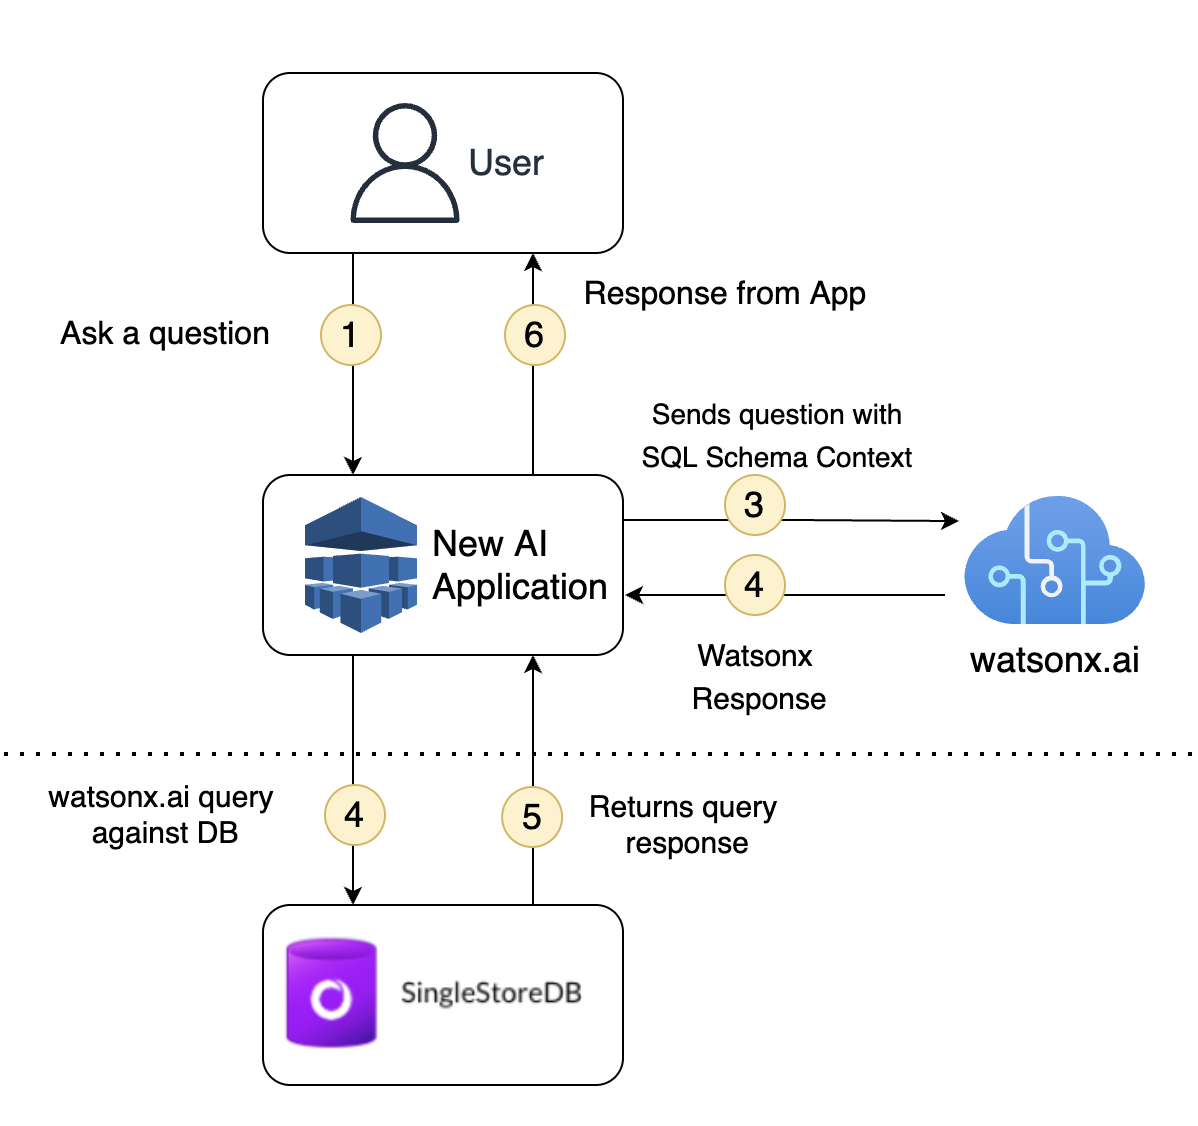

### Install and import dependencies

In [1]:
import os, getpass
import pandas as pd
from typing import Optional, Dict, Any, Iterable, List
from dotenv import load_dotenv
from sqlalchemy import *
#from sqlalchemy import create_engine
from langchain.vectorstores import SingleStoreDB
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes
from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams
from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes, DecodingMethods

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    raise ImportError("Could not import sentence_transformers: Please install sentence-transformers package.")

### SingleStoreDB connection

Those cells defines the credentials required to work with SingleStoreDB. 

Make sure that you have a database created in SingleStoreDB called **watsonx_ibm_lab2**

**Action** Make sure to add the `.env` with the API Keys, Passwords, IDs, and Host information to the base directory from where this lab is located

In [2]:
#config watsonx.ai environment
load_dotenv()
ibm_apikey = os.getenv("IBM_APIKEY", None)
watson_project_id = os.getenv("PROJECT_ID", None)
ssdb_password = os.getenv("SSDB_PASSWORD", None)
ssdb_host = os.getenv("SSDB_HOST", None)

if ibm_apikey is None or ssdb_password is None or ssdb_host is None or watson_project_id is None:
    print("ERROR: DO NOT PROGRESS UNTILL YOU FIX THIS: Ensure you copied the .env file that you created earlier into the same directory as this notebook")

**Action** Update the database_name to the workspace given to you by the instructor.

In [3]:
connection_user = 'admin'
connection_password = ssdb_password
connection_port = '3306'
connection_host = ssdb_host
database_name = 'watsonx_ibm_lab2'

In [4]:
# Connection string to use Langchain with SingleStoreDB
os.environ["SINGLESTOREDB_URL"] = f"{connection_user}:{connection_password}@{connection_host}:{connection_port}/{database_name}"

# With database connection URL
connection_url = f"singlestoredb://{connection_user}:{connection_password}@{connection_host}:{connection_port}/{database_name}"
engine = create_engine(connection_url)

### Singlestore Table and Mock Data creation

The following cells will create 3 tables for this lab.

In [6]:
# Create tables in SingleStoreDB
create_table_query1 = """
CREATE TABLE IF NOT EXISTS Users (
    UserID INT PRIMARY KEY,
    UserName VARCHAR(255),
    Email VARCHAR(255),
    PhoneNumber VARCHAR(15)
)
"""
create_table_query2 = """
CREATE TABLE IF NOT EXISTS Products (
    ProductID INT PRIMARY KEY,
    ProductName VARCHAR(255),
    Price DECIMAL(10, 2)
)"""
create_table_query3 = """
CREATE TABLE IF NOT EXISTS Orders (
    OrderID INT PRIMARY KEY,
    UserID INT,
    ProductID INT,
    Quantity INT,
    OrderDate DATETIME
)
"""
with engine.connect() as conn:
     res = conn.execute(text(create_table_query1))
     res = conn.execute(text(create_table_query2))
     res = conn.execute(text(create_table_query3))


The next cell can be `[IGNORED]` if the data has already been added previously, otherwise you can uncomment the following section and run it.


In [7]:
# IGNORE THIS SECTION IF THE CONTENTS HAVE ALREADY BEEN ADDED TO THE TABLES


# create_user_data = """
# INSERT INTO Users (UserID, UserName, Email, PhoneNumber)
# VALUES
#     (1, 'Alice', 'alice@email.com', '555-1234'),
#     (2, 'Bob', 'bob@email.com', '555-5678'),
#     (3, 'Charlie', 'charlie@email.com', '555-91011');
# """
# create_prod_data = """
# INSERT INTO Products (ProductID, ProductName, Price)
# VALUES
#     (1, 'Laptop', 800.00),
#     (2, 'Smartphone', 300.00),
#     (3, 'Headphones', 50.00)"""
# create_order_data = """
# INSERT INTO Orders (OrderID, UserID, ProductID, Quantity, OrderDate)
# VALUES
#     (101, 1, 1, 2, '2023-01-10 08:30:00'),
#     (102, 1, 2, 1, '2023-01-12 12:15:00'),
#     (103, 2, 3, 3, '2023-01-15 16:45:00'),
#     (104, 3, 1, 1, '2023-01-20 09:00:00')"""

# with engine.connect() as conn:
#      res = conn.execute(text(create_user_data))
#      res = conn.execute(text(create_prod_data))
#      res = conn.execute(text(create_order_data))
#      print(res)

### watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

In [8]:
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": ibm_apikey
}


### Defining the project id
The API requires project id that provides the context for the call. We will obtain the id from the `.env` PROJECT_ID in which this notebook runs.

In [9]:

project_id = watson_project_id

### Defining the model parameters
We need to provide a set of model parameters that will influence the result:

In [10]:
generate_parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.GREEDY,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.MAX_NEW_TOKENS: 100
}

### List available models

In [11]:
print([e.value for e in ModelTypes])

['google/flan-t5-xxl', 'google/flan-ul2', 'bigscience/mt0-xxl', 'eleutherai/gpt-neox-20b', 'ibm/mpt-7b-instruct2', 'bigcode/starcoder', 'meta-llama/llama-2-70b-chat', 'meta-llama/llama-2-13b-chat', 'ibm/granite-13b-instruct-v1', 'ibm/granite-13b-chat-v1']


Pick one LLM model (e.g. FLAN_UL2, STARCODER)

In [25]:
llm_model = 'ibm/granite-13b-chat-v1'

Initialize the `Model` class.

In [26]:
model = Model(
    model_id=llm_model,
    params=generate_parameters,
    credentials=wml_credentials,
    project_id=project_id
)

In [27]:
from ibm_watson_machine_learning.foundation_models.extensions.langchain import WatsonxLLM
llm_model = WatsonxLLM(model=model)

<a id="predict"></a>
## Create schema prompt based on the database design

### Create a SQL Scheme CodeGen Prompt

Setup the schema based on the database

In [28]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [29]:
context = """
(1) Database Table Name: Users
Column Name # Meaning
UserID      # User ID
UserName    # User's Name
Email       # User's Email
PhoneNumber # User's Phone Number
(2) Database Table Name: Products
Column Name # Meaning
ProductID   # Product ID
ProductName # Product Name
Price       # Product Price
(3) Database Table Name: Orders
Column Name # Meaning
OrderID     # Order ID
UserID      # User ID (Foreign Key)
ProductID   # Product ID (Foreign Key)
Quantity    # Order Quantity
OrderDate   # Date of Order

input: Retrieve the information of all users from the Users table.
output: SELECT * FROM Users;
input: Retrieve the order details (OrderID, ProductID, Quantity) for the user Bob.
output: SELECT OrderID, ProductID, Quantity FROM Orders WHERE UserName= "Bob";
input: Calculate the total number of orders placed each month.
output: SELECT MONTH(OrderDate) AS Month, COUNT(*) AS OrderCount FROM Orders GROUP BY MONTH(OrderDate) ORDER BY Month;
input: Calculate the total value of all orders by multiplying the quantity by the price for each product in the Orders table.
output: SELECT o.OrderID, o.ProductID, o.Quantity, p.Price, o.Quantity * p.Price AS TotalValue FROM Orders o JOIN Products p ON o.ProductID = p.ProductID;
input: Identify the top 2 customers who have spent the most money on orders, including their total spending amount.
output: SELECT u.UserID, u.UserName, SUM(p.Price * o.Quantity) AS TotalSpending FROM Users u JOIN Orders o ON u.UserID = o.UserID JOIN Products p ON o.ProductID = p.ProductID GROUP BY u.UserID, u.UserName ORDER BY TotalSpending DESC LIMIT 3;
input: List all orders with user and product details.
output: SELECT o.OrderID, u.UserName, p.ProductName, o.Quantity, o.OrderDate FROM Orders o JOIN Users u ON o.UserID = u.UserID JOIN Products p ON o.ProductID = p.ProductID; 
"""

### Query question against schema to create a SELECT statement.

Get questions from the previously loaded test dataset.

In [30]:
template = """Given the context: {context}

Input: {query}
Output: """

prompt = PromptTemplate (
    template=template,
    input_variables=["context", "query"]
)

### Apply the query against the database.

In [31]:
# query = "Display the names and prices of all products from the Products table."
query = "Show the total spending for each user."

partial_prompt = prompt.partial(context=context)
print(partial_prompt.format(query=query))

Given the context: 
(1) Database Table Name: Users
Column Name # Meaning
UserID      # User ID
UserName    # User's Name
Email       # User's Email
PhoneNumber # User's Phone Number
(2) Database Table Name: Products
Column Name # Meaning
ProductID   # Product ID
ProductName # Product Name
Price       # Product Price
(3) Database Table Name: Orders
Column Name # Meaning
OrderID     # Order ID
UserID      # User ID (Foreign Key)
ProductID   # Product ID (Foreign Key)
Quantity    # Order Quantity
OrderDate   # Date of Order

input: Retrieve the information of all users from the Users table.
output: SELECT * FROM Users;
input: Retrieve the order details (OrderID, ProductID, Quantity) for the user Bob.
output: SELECT OrderID, ProductID, Quantity FROM Orders WHERE UserName= "Bob";
input: Calculate the total number of orders placed each month.
output: SELECT MONTH(OrderDate) AS Month, COUNT(*) AS OrderCount FROM Orders GROUP BY MONTH(OrderDate) ORDER BY Month;
input: Calculate the total value

In [32]:
llm_chain = LLMChain(prompt=partial_prompt, llm=llm_model)

sql_query = llm_chain.run(query)

print(sql_query)


SELECT u.UserName, SUM(p.Price * o.Quantity) AS TotalSpending FROM Users u JOIN Orders o ON u.UserID = o.UserID JOIN Products p ON o.ProductID = p.ProductID GROUP BY u.UserName


In [33]:
#Sanitize the query

import re

sanitized_sql = re.sub(r'\n', '', sql_query.strip())
sanitized_sql = sanitized_sql.replace('<|endoftext|>', '')

print(sanitized_sql)

SELECT u.UserName, SUM(p.Price * o.Quantity) AS TotalSpending FROM Users u JOIN Orders o ON u.UserID = o.UserID JOIN Products p ON o.ProductID = p.ProductID GROUP BY u.UserName


In [34]:
with engine.connect() as conn:
     res = conn.execute(text(sanitized_sql))
     results = res.fetchall()
     print(results)

[('Bob', Decimal('150.00')), ('Alice', Decimal('1900.00')), ('Charlie', Decimal('800.00'))]


<div class="alert alert-block alert-success">
    <b class="fa fa-solid fa-check-circle"></b>
    <div>
        <p><b>Success</b></p>
        <p>You are done with the demo and you can see how we can use NLP to create a query and then apply the query against the database</p>
    </div>
</div>

Copyright © 2023 IBM. This notebook and its source code are released under the terms of the MIT License.